In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "/data2/yuanshou/tmp/sdwebui/models/sdv15/stable-diffusion-v1-5",
    revision="fp16", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
import itertools
import math
import mediapy as media

In [5]:
!mkdir diffprocess

mkdir: cannot create directory ‘diffprocess’: File exists


In [6]:
@torch.no_grad() # save the gpu memory
def plot_show_callback(_,i, t, latents):
    # latents = latents['latents']
    latents_reservoir.append(latents.detach().cpu())
    image = pipe.vae.decode(1 / 0.18215 * latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    # plt_show_image(image)
    plt.imsave(f"diffprocess/sample_{i:02d}.png", image)
    image_reservoir.append(image)


@torch.no_grad() # save the gpu memory
def save_latents(i, t, latents):
    latents_reservoir.append(latents.detach().cpu())

image_reservoir = []
latents_reservoir = []

In [7]:
def latents_to_rgb(latents):
    weights = (
        (60, -60, 25, -70),
        (60,  -5, 15, -50),
        (60,  10, -5, -35)
    )

    weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
    biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
    rgb_tensor = torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)
    image_array = rgb_tensor.clamp(0, 255)[0].byte().cpu().numpy()
    image_array = image_array.transpose(1, 2, 0)

    return Image.fromarray(image_array)

In [8]:
def decode_tensors(pipe, step, timestep, callback_kwargs):
    latents = callback_kwargs["latents"]
    latents_reservoir.append(latents.detach().cpu())
    latents_reservoir.append(latents.detach().cpu())
    image = pipe.vae.decode(1 / 0.18215 * latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    # plt_show_image(image)
    # plt.imsave(f"diffprocess/sample_{i:02d}.png", image)
    image_reservoir.append(image)
    image = latents_to_rgb(latents)
    
    image.save(f"{step}.png")

    return callback_kwargs

  0%|          | 0/50 [00:00<?, ?it/s]

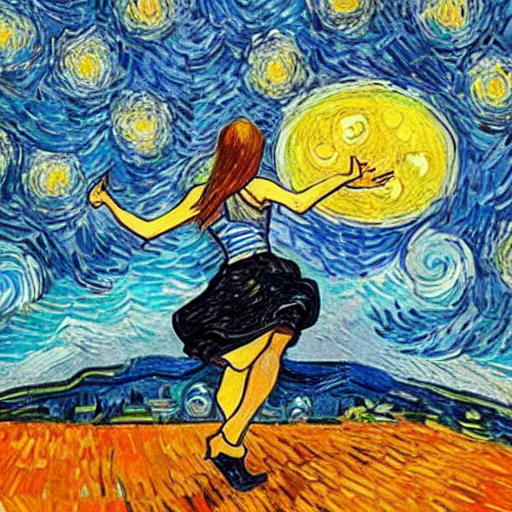

In [9]:
from PIL import Image
prompt = "a girl dancing in the moonlight in van gogh style, trending art."
with torch.no_grad():
  image = pipe(prompt,
               callback_on_step_end=decode_tensors,
    callback_on_step_end_tensor_inputs=["latents"],).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)
image.save(f"gentle_girl.png")
image

In [12]:
media.show_video(image_reservoir, fps=5)

In [13]:
image_reservoir

[array([[[0.71875   , 0.7285156 , 0.7026367 ],
         [0.73046875, 0.734375  , 0.70703125],
         [0.72558594, 0.7207031 , 0.7060547 ],
         ...,
         [0.49194336, 0.49291992, 0.42163086],
         [0.58203125, 0.58691406, 0.49438477],
         [0.5732422 , 0.55322266, 0.47705078]],
 
        [[0.76904297, 0.7998047 , 0.7788086 ],
         [0.7753906 , 0.8359375 , 0.8305664 ],
         [0.765625  , 0.86035156, 0.85253906],
         ...,
         [0.35766602, 0.39819336, 0.3305664 ],
         [0.57177734, 0.6245117 , 0.5126953 ],
         [0.6845703 , 0.6308594 , 0.56347656]],
 
        [[0.8198242 , 0.87841797, 0.8652344 ],
         [0.828125  , 0.93359375, 0.9345703 ],
         [0.8310547 , 0.9614258 , 0.9628906 ],
         ...,
         [0.29492188, 0.36083984, 0.26586914],
         [0.51171875, 0.5878906 , 0.5       ],
         [0.6538086 , 0.65283203, 0.58740234]],
 
        ...,
 
        [[0.97265625, 1.        , 1.        ],
         [0.98828125, 1.        , 1.     

# visualizing latents

In [14]:
latents_reservoir[0].shape, image_reservoir[0].shape

(torch.Size([1, 4, 64, 64]), (512, 512, 3))

In [15]:
Chan2RGB = [0,1,2]
latents_np_seq = [latent[0, Chan2RGB].permute(1,2,0).numpy() for latent in latents_reservoir]


In [19]:
media.show_video(latents_np_seq, fps=5)

In [ ]:
# 1. diffusers api [optional]
# 2. jump into training with diffusers